In [6]:
import sys
sys.path.append('../src')

In [8]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np

In [9]:
path_sp_watershed2 = "/workspaces/Importance-Sampling-for-SST/data/0_source/huc_150602/watershed_150602_wgs.geojson"
sp_watershed2 = gpd.read_file(path_sp_watershed2)

In [10]:

def centroid_fallback_inside(gdf, resolution=0.005):
    poly = gdf.geometry.iloc[0]
    if poly.contains(centroid):
        return centroid

    minx, miny, maxx, maxy = poly.bounds
    xs = np.arange(minx, maxx, resolution)
    ys = np.arange(miny, maxy, resolution)
    interior_points = [Point(x, y) for x in xs for y in ys if poly.contains(Point(x, y))]

    return min(interior_points, key=lambda p: p.distance(centroid)) if interior_points else centroid

In [11]:
def get_fast_medoid(gdf, resolution=0.01):
    poly = gdf.geometry.iloc[0]
    minx, miny, maxx, maxy = poly.bounds
    xs = np.arange(minx, maxx, resolution)
    ys = np.arange(miny, maxy, resolution)

    # Sample grid points inside polygon
    points = [Point(x, y) for x in xs for y in ys if poly.contains(Point(x, y))]
    if not points:
        return poly.centroid  # fallback

    # Find the point with the minimum total distance to all others
    distances = np.array([[p1.distance(p2) for p2 in points] for p1 in points])
    medoid_idx = np.argmin(distances.sum(axis=1))

    return points[medoid_idx]

In [12]:
centroid = sp_watershed2.geometry.centroid.iloc[0]
rep_point = sp_watershed2.geometry.representative_point().iloc[0]
fallback_point = centroid_fallback_inside(sp_watershed2)
medoid = get_fast_medoid(sp_watershed2, resolution=0.05)

/tmp/ipykernel_11461/3147556882.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = sp_watershed2.geometry.centroid.iloc[0]


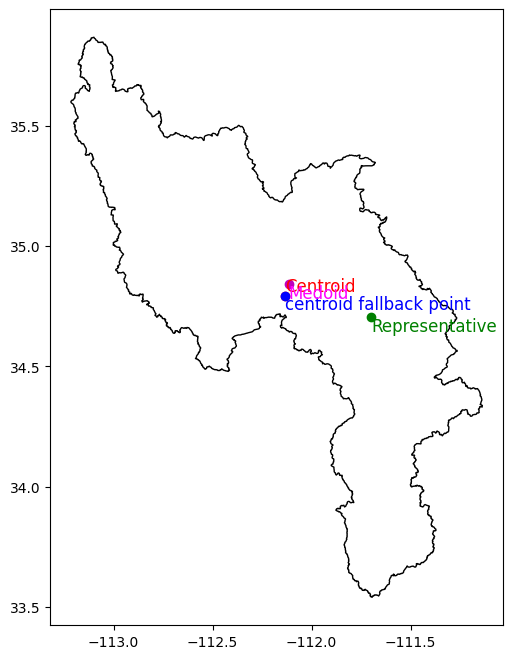

In [13]:
ax = sp_watershed2.plot(edgecolor='black', facecolor='none', figsize=(8, 8))
plt.plot(centroid.x, centroid.y, 'ro')
plt.plot(rep_point.x, rep_point.y, 'go', label='Representative Point')
plt.plot(fallback_point.x, fallback_point.y, 'bo', label='Fallback Inside')
plt.plot(medoid.x, medoid.y, 'mo', label='Medoid')

ax.text(centroid.x, centroid.y, "Centroid", fontsize=12, color='red', ha='left', va='bottom')
ax.text(rep_point.x, rep_point.y, "Representative", fontsize=12, color='green', ha='left', va='top')
ax.text(fallback_point.x, fallback_point.y, "centroid fallback point", fontsize=12, color='blue', ha='left', va='top')
ax.text(medoid.x, medoid.y, "Medoid", fontsize=12, color='magenta', ha='left', va='top')
plt.show()